In [23]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import mlflow
import mlflow.keras




# Step 1: Isolate the Rossmann Store Sales Dataset into Time Series Data

In [24]:
# Loading the training dataset
df_train = pd.read_csv('df_train.csv')


# Converting the 'Date' column to datetime and set it as index
df_train['Date'] = pd.to_datetime(df_train['Date'])
df_train.set_index('Date', inplace=True)

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_6340\123461062.py:2: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df_train = pd.read_csv('df_train.csv')


In [25]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 927989 entries, 2015-07-31 to 2013-01-01
Data columns (total 17 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   Store                      927989 non-null  int64  
 1   DayOfWeek                  927989 non-null  int64  
 2   Sales                      927989 non-null  int64  
 3   Customers                  927989 non-null  int64  
 4   Open                       927989 non-null  int64  
 5   Promo                      927989 non-null  int64  
 6   StateHoliday               927989 non-null  object 
 7   SchoolHoliday              927989 non-null  int64  
 8   StoreType                  927989 non-null  object 
 9   Assortment                 927989 non-null  object 
 10  CompetitionDistance        927989 non-null  float64
 11  CompetitionOpenSinceMonth  927989 non-null  int64  
 12  CompetitionOpenSinceYear   927989 non-null  int64  
 13  Promo2       

In [27]:
df_train['StateHoliday'] = df_train['StateHoliday'].astype(str)

In [28]:
# Isolating the Sales data
sales_data = df_train['Sales']

In [29]:
print(sales_data.isna().sum())


0


In [30]:
adf_result = adfuller(sales_data.dropna(), maxlag=10)


# Step 2: Check Whether Your Time Series Data is Stationary

In [31]:
# Perform ADF test on sales data
print('ADF Statistic:', adf_result[0])
print('p-value:', adf_result[1])

# Check the p-value; if it is greater than 0.05, the data is non-stationary
if adf_result[1] > 0.05:
    print("The data is non-stationary.")

ADF Statistic: -56.62430881041457
p-value: 0.0


<font size = '5'>

INTERPRETATION:

<font size = '3'>


1. ADF Statistic:  As the ADF Statistic is negative, the more negative the ADF Statistic, the stronger the evidence against the null hypothesis.
2. p-Value:  The p-value is 0.0 which is less than 0.05 indicates the strong evidence against the null hypothesis which means we can reject the null hypothesis



This means that the TIME SERIES DATA IS STATIONARY


<FONT SIZE = '7'>

 Step 3:  Depending on your conclusion from 2 above difference the time series data

 <FONT SIZE = '4'>

 There is no need of differencing the time series data as the time series data is already stationary.

In [32]:
sales_data_subset = sales_data.head(50000)

<Figure size 1200x600 with 0 Axes>

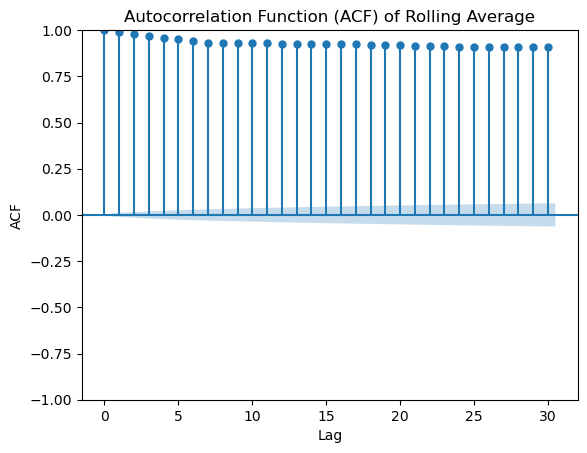

In [33]:
# Set the rolling window size (e.g., 7 days)
window_size = 7  # Adjust as necessary for your analysis

# Calculate the rolling average
rolling_average = sales_data_subset.rolling(window=window_size).mean()


# Drop NaN values resulting from rolling average
rolling_average = rolling_average.dropna()

# Plot ACF for the rolling average
plt.figure(figsize=(12, 6))
plot_acf(rolling_average, lags=30)  # Adjust the number of lags as needed
plt.title('Autocorrelation Function (ACF) of Rolling Average')
plt.xlabel('Lag')
plt.ylabel('ACF')
plt.show()



<font size = '5'>
INTERPRETATION:
<font size = '3'>

High autocorrelation at all lags: The ACF values are close to 1 across all lags and this indicates that the rolling average sales data is hightly autocorrelated.
Shaded confidence interval:  All the autocorrelation points fall outside the region(blue shade), this indicates that the autocorrelations are significant for all lags and hence the sales data is not random but follows a structured pattern.

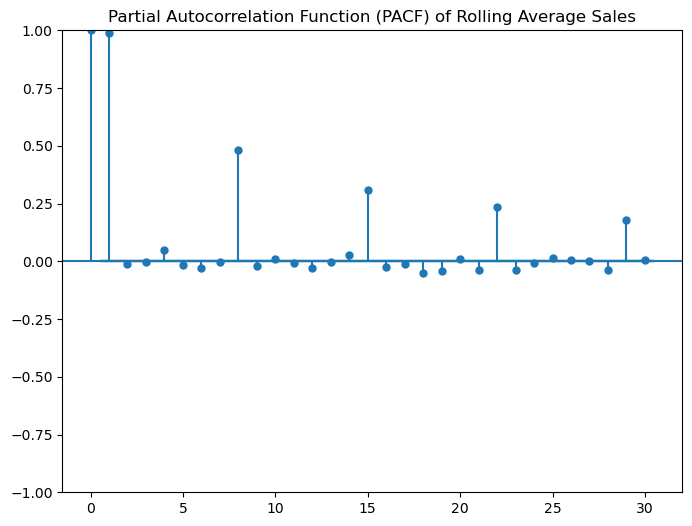

In [34]:
fig, ax = plt.subplots(figsize=(8, 6))
plot_pacf(rolling_average, lags=30, ax=ax)
plt.title('Partial Autocorrelation Function (PACF) of Rolling Average Sales')
plt.show()

<font size = '5'>
INTERPRETATION:
<font size ='3'>

Significant lag at 1:  The first lag shows a PACF value of nearly 1 indicating a very strong direct relationship between the current sales and the sales from one lag prior. This gives us a picture that the sales from the immediately preceding period have a very strong influence on current period.

Significant drop after lag 1:  After lag 1 there is a drop in PACF value.  This pattern suggests that the effect of sales data beyone one lag diminishes significantly after controlling for the effect of the first lag.  this shows a typical behavior of autoregressive of order 1 where the current value is primarily dependent on the immediately preceding value.

Other Significant lags: There are notable lags at 10,15,and 25 but they are much smaller in comparison.  These lags show some influence but are much weaker.

Non-significant lags:  Most other lags fall within the confidence interval, indicating that the PACF at these lags are not statistically significant.

<font size = '5'>
Step 5:  Transform the time series data into supervised learning data by creating a new
 y(target) column. For example as illustrated here in the Sliding Window For Time
 Series Data section

In [35]:
# Creating a function to transform time series into supervised data
def create_supervised_data(series, n_lags=1):
    
    df = pd.DataFrame(series)
    
    columns = []
    
    # Create lag features (shifting by 1, 2, ..., n_lags)
    for i in range(n_lags, 0, -1):
        df[f'lag_{i}'] = df[series.name].shift(i)
    
    # The current time step is the target (y)
    df['y'] = df[series.name]
    
    # Drop rows with NaN values created by shifting
    df.dropna(inplace=True)
    
    return df

# Set the number of lag features (e.g., 3 previous time steps as features)
n_lags = 3

# Create the supervised dataset using the rolling average data
supervised_data = create_supervised_data(rolling_average, n_lags=n_lags)

# View the first few rows of the transformed supervised dataset
print(supervised_data.head())

                  Sales        lag_3        lag_2        lag_1            y
Date                                                                       
2015-07-31  9043.428571  8049.142857  8323.714286  8951.285714  9043.428571
2015-07-31  8304.285714  8323.714286  8951.285714  9043.428571  8304.285714
2015-07-31  8431.857143  8951.285714  9043.428571  8304.285714  8431.857143
2015-07-31  8531.714286  9043.428571  8304.285714  8431.857143  8531.714286
2015-07-31  8769.714286  8304.285714  8431.857143  8531.714286  8769.714286


<font size = '5'>
Step 6:   Scale your data in the (-1, 1) range

In [36]:
# Function to scale the supervised learning data between (-1, 1)
def scale_data(df, feature_range=(-1, 1)):
    
    scaler = MinMaxScaler(feature_range=feature_range)
    
    # Fitting and transforming the data using the scaler
    scaled_values = scaler.fit_transform(df)
    
    # Converting the scaled data back into a DataFrame with the original column names
    scaled_df = pd.DataFrame(scaled_values, columns=df.columns, index=df.index)
    
    return scaled_df, scaler

# Apply the scaling to the supervised learning data
scaled_supervised_data, scaler = scale_data(supervised_data)

# View the scaled data
print(scaled_supervised_data.head())


               Sales     lag_3     lag_2     lag_1         y
Date                                                        
2015-07-31  0.362182  0.212416  0.253774  0.348303  0.362182
2015-07-31  0.250847  0.253774  0.348303  0.362182  0.250847
2015-07-31  0.270063  0.348303  0.362182  0.250847  0.270063
2015-07-31  0.285104  0.362182  0.250847  0.270063  0.285104
2015-07-31  0.320953  0.250847  0.270063  0.285104  0.320953


In [37]:
print(scaled_supervised_data.columns)

Index(['Sales', 'lag_3', 'lag_2', 'lag_1', 'y'], dtype='object')


In [38]:
# Function to create a dataset for LSTM with time steps
def create_dataset(X, y, time_steps=1):
    
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X[i:(i + time_steps), :]
        Xs.append(v)
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

# Load and preprocess data (assuming your 'supervised_data' is already created)
# For this example, let's assume `supervised_data` is already your scaled supervised dataframe
# and has been appropriately prepared.

# Split data into features (X) and target (y)
X = scaled_supervised_data.drop(columns=['y']).values  # Lag features
y = scaled_supervised_data['y'].values  # Target column

# Define time_steps (this will determine how many previous lags we use)
time_steps = 3  # Use 3 previous time steps

# Prepare the data for LSTM (reshaping into 3D [samples, timesteps, features])
X_lstm, y_lstm = create_dataset(X, y, time_steps)

# Split the dataset into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X_lstm, y_lstm, test_size=0.2, shuffle=False)

# Reshape X_train and X_test to be 3D (samples, timesteps, features) - already done by create_dataset

# Print the shape of the training data to verify
print("Training data shape:", X_train.shape)  # (samples, timesteps, features)

# --- Build the LSTM Model ---

# Initialize the LSTM model
model = Sequential()

# Add an LSTM layer with 50 units and input shape (timesteps, number of features)
model.add(LSTM(units=50, return_sequences=False, input_shape=(X_train.shape[1], X_train.shape[2])))

# Add a Dense output layer with 1 unit (regression task)
model.add(Dense(1))

# Compile the model using MSE loss and Adam optimizer
model.compile(loss='mean_squared_error', optimizer='adam')

# --- Train the model ---
history = model.fit(X_train, y_train, epochs=20, batch_size=64, validation_data=(X_test, y_test), verbose=2)

# --- Make predictions ---
y_pred = model.predict(X_test)

# --- Inverse transform the predictions and actuals back to original scale ---

# Since we are only scaling the target variable 'y', we need a separate scaler for 'y'
y_scaler = MinMaxScaler()

# Fit the scaler on the original 'y' column before it was scaled (assumed to be 'target' column from the original dataset)
y_scaler.fit(supervised_data[['y']])

# Inverse transform the predicted and actual values
y_pred_rescaled = y_scaler.inverse_transform(y_pred)
y_test_rescaled = y_scaler.inverse_transform(y_test.reshape(-1, 1))


Training data shape: (39990, 3, 4)
Epoch 1/20


c:\Users\Lenovo\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


625/625 - 6s - 9ms/step - loss: 0.0109 - val_loss: 0.0057
Epoch 2/20
625/625 - 5s - 8ms/step - loss: 0.0047 - val_loss: 0.0040
Epoch 3/20
625/625 - 3s - 4ms/step - loss: 0.0037 - val_loss: 0.0037
Epoch 4/20
625/625 - 3s - 4ms/step - loss: 0.0036 - val_loss: 0.0038
Epoch 5/20
625/625 - 2s - 4ms/step - loss: 0.0036 - val_loss: 0.0040
Epoch 6/20
625/625 - 3s - 4ms/step - loss: 0.0036 - val_loss: 0.0037
Epoch 7/20
625/625 - 3s - 4ms/step - loss: 0.0036 - val_loss: 0.0037
Epoch 8/20
625/625 - 3s - 4ms/step - loss: 0.0036 - val_loss: 0.0037
Epoch 9/20
625/625 - 3s - 4ms/step - loss: 0.0036 - val_loss: 0.0037
Epoch 10/20
625/625 - 3s - 4ms/step - loss: 0.0036 - val_loss: 0.0037
Epoch 11/20
625/625 - 3s - 4ms/step - loss: 0.0036 - val_loss: 0.0037
Epoch 12/20
625/625 - 3s - 4ms/step - loss: 0.0036 - val_loss: 0.0037
Epoch 13/20
625/625 - 3s - 4ms/step - loss: 0.0036 - val_loss: 0.0038
Epoch 14/20
625/625 - 3s - 4ms/step - loss: 0.0036 - val_loss: 0.0037
Epoch 15/20
625/625 - 2s - 4ms/step - lo

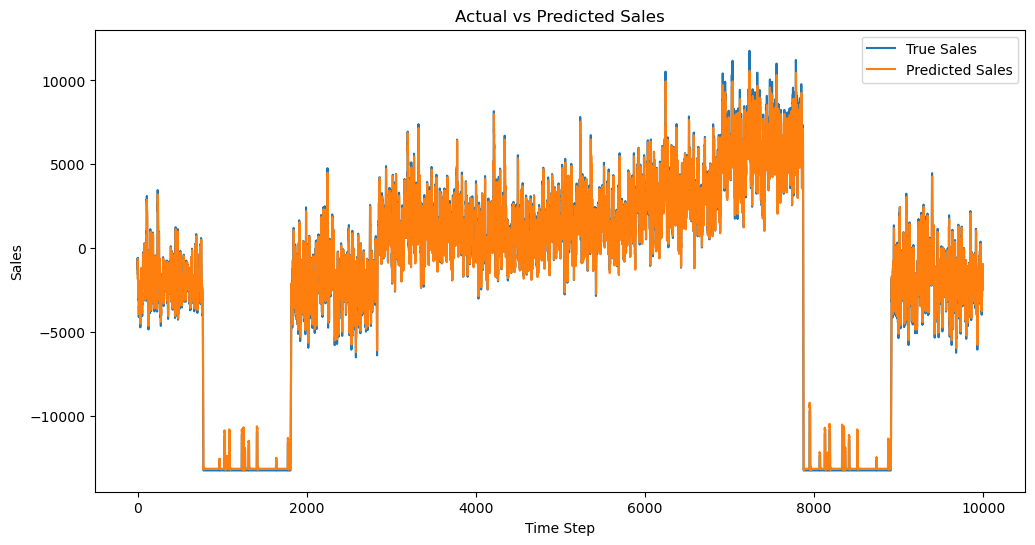

In [39]:
# --- Plot the results ---

plt.figure(figsize=(12, 6))
plt.plot(y_test_rescaled, label='True Sales')
plt.plot(y_pred_rescaled, label='Predicted Sales')
plt.title('Actual vs Predicted Sales')
plt.xlabel('Time Step')
plt.ylabel('Sales')
plt.legend()
plt.show()

In [40]:
# Evaluating the model performance
mse = mean_squared_error(y_test_rescaled, y_pred_rescaled)
# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_rescaled, y_pred_rescaled)


print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"R-squared: {r2}")


Mean Squared Error: 647420.7741149531
Root Mean Squared Error: 804.6246168959493
R-squared: 0.984032455625176


In [42]:
import mlflow.keras

# Assuming 'model' is your LSTM model
# Check the model summary
model.summary()

# Check the input shape
input_shape = model.input_shape
print("Input shape of the model:", input_shape)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 50)             │        11,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,155 (129.52 KB)

 Trainable params: 11,051 (43.17 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 22,104 (86.35 KB)

Input shape of the model: (None, 3, 4)


In [44]:
df_train = pd.read_csv('df_train.csv', dtype={'StateHoliday': 'str'}, low_memory=False)


In [22]:
df_train = pd.read_csv('df_train.csv')
print(df_train.dtypes)


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_6340\2315881852.py:1: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df_train = pd.read_csv('df_train.csv')


Store                          int64
DayOfWeek                      int64
Date                          object
Sales                          int64
Customers                      int64
Open                           int64
Promo                          int64
StateHoliday                  object
SchoolHoliday                  int64
StoreType                     object
Assortment                    object
CompetitionDistance          float64
CompetitionOpenSinceMonth      int64
CompetitionOpenSinceYear       int64
Promo2                         int64
Promo2SinceWeek                int64
Promo2SinceYear                int64
PromoInterval                 object
dtype: object
